In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
from scipy import fftpack as spfft # for computing spectra
import librosa
import resampy
from subprocess import call

%matplotlib inline

# Set plot fontsize
matplotlib.rcParams.update({'font.size': 22})

Direct sonification is simply the process of changing the time scale of a signal to transpose it to the audible range. The data should therefore have similarities with sound waves in air, that is:

 - oscillations around an average value (better if this value is 0), a.k.a "stationary" data. 
 - not a vast range of amplitudes in the thing of interest
 - enough cycles to produce sound at the new frequency. 

We take the example of seismic data... but they could be many other things, e.g.:

[planetary:] 

 - ocean waves, tidal data
 - electro-magnetic waves (solar winds?)
 - gravitational waves
 - planetary orbital positions
 
[biological:] 

 - waves created by in blood circulation
 - ekg waves?
 
[sociological:] 
 - ? 

# EXAMPLE 1: a large earthquake 


## 1. Get the data (and in to python):

In [2]:
DirIn = '../0_data_nogit/'
DirOut = '../3_output_nogit/'

# (get the data first from the google drive for class-- and put it in the DirIn )
# This is the Tohoku earthquake (2011), recorded by a seimic station located in Central USA
FileNameIn = 'P39A.BHZ' # Note that this data has been pre-processed (instrument response removal)
sr = 20 # Datatype BHZ is sampled at 20 Hz
# In this case, you need to get the info from the data source. ) 

data = np.loadtxt(DirIn + FileNameIn)
duration = len(data)/sr
print('We have ' + str(int(duration)) + ' seconds of data!')
print('... which is ' + str(int(duration/3600)) + ' hours of data!')

# make time vectors for plotting purposes only
t = np.arange(0,duration,1./sr) # in seconds
t_hours = np.arange(0,duration/3600,1./sr/3600) # in hours

We have 50400 seconds of data!
... which is 14 hours of data!


In [3]:
# Compute the spectrum
Nfft = len(data)
f = np.arange(0,sr/2,sr/Nfft)
S = spfft.fft(data,Nfft); S = S[:int(Nfft/2)]
print('Frequency content ranges from ' + str(f[0]) + ' to ' + str(round(f[-1],3)) + ' Hz...')
print('Frequency content ranges from ' + str(np.log10(f[1])) + ' to ' + str(np.log10(f[-1])) + ' [log10(Hz)]')

Frequency content ranges from 0.0 to 10.0 Hz...
Frequency content ranges from -4.70243053645 to 0.999999138304 [log10(Hz)]


(-0.49999900793650798,
 10.499979166666666,
 -201.96264812121126,
 33.600228586148312)

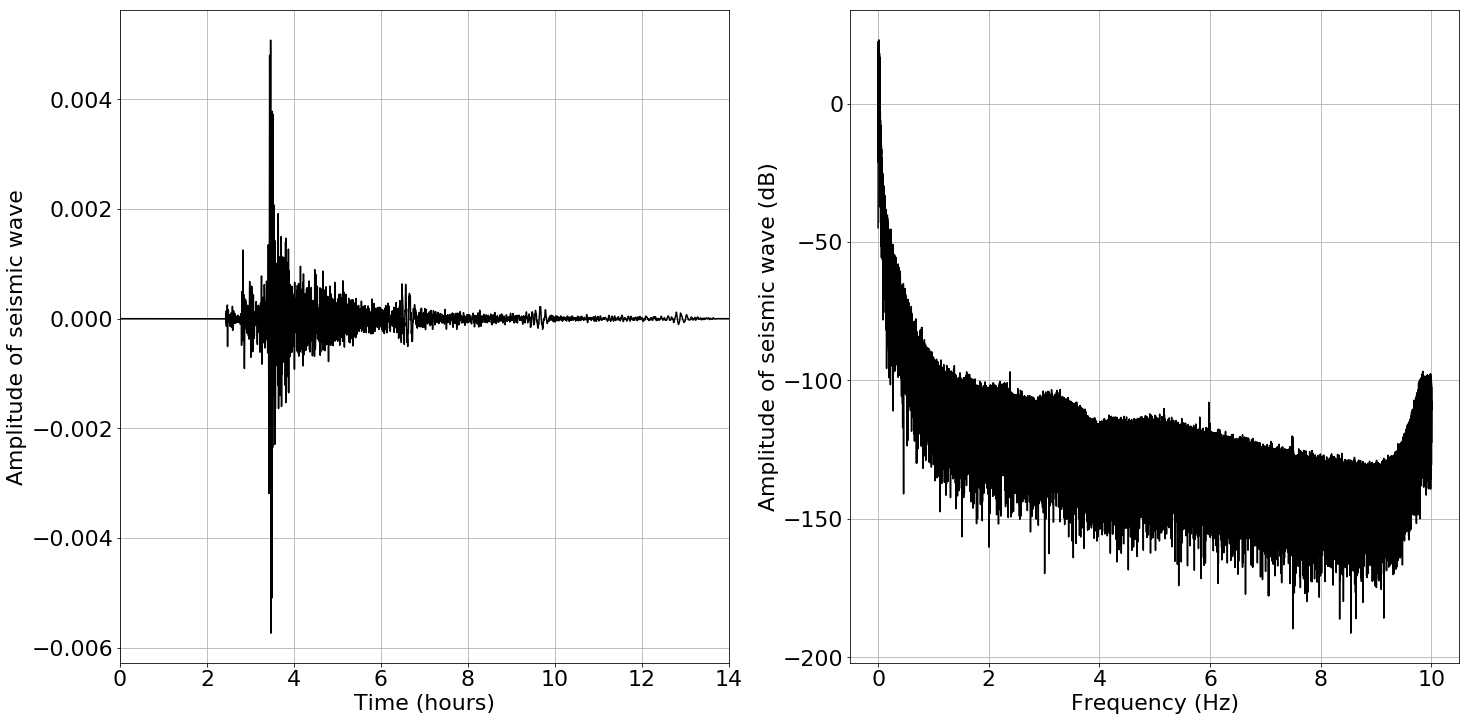

In [4]:
plt.figure(figsize=(12*2,6*2))
plt.subplot(1,2,1)
plt.plot(t_hours,data,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave')
plt.grid()
plt.xlim([0,duration/3600])
plt.subplot(1,2,2)
plt.plot(f,20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()
plt.axis()

## NOW MAKE SOUND !

In [5]:
###### some useful prerequisites...

# 1) force the signal's mean value to be zero (how to kill your loudspeakers...)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers...)
# a simple way is to normalize the data according to its maximum amplitude value
# data = data/np.amax(data) # This is dangerous, peak values can be negative, too
data_n = data/np.amax(np.absolute(data))

/Users/ben/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


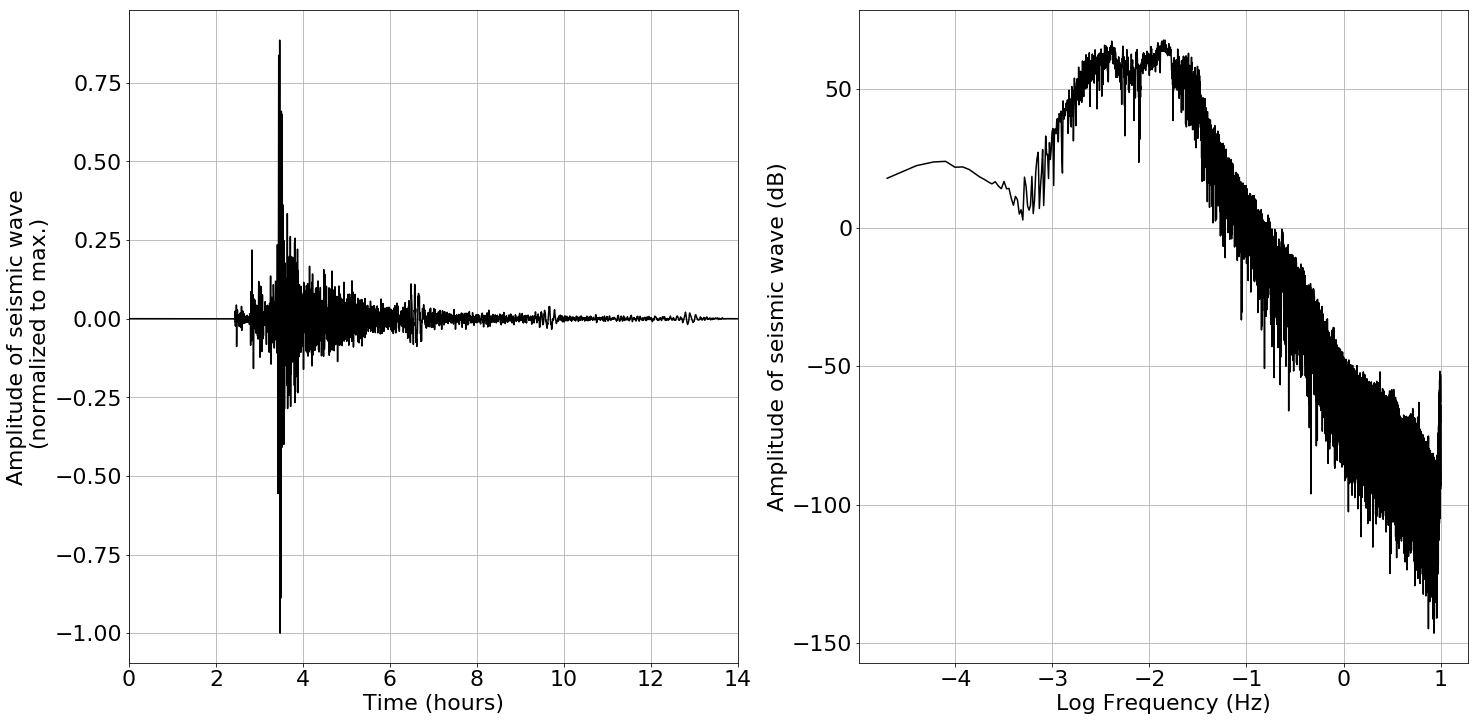

In [6]:
# plot again
S = spfft.fft(data_n,Nfft)
S = S[:int(Nfft/2)]

plt.figure(figsize=(12*2,6*2))
plt.subplot(1,2,1)
plt.plot(t_hours,data_n,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave\n (normalized to max.)')
plt.grid()
plt.xlim([0,duration/3600])
plt.subplot(1,2,2)
plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Log Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()

Text(0,0.5,'dB')

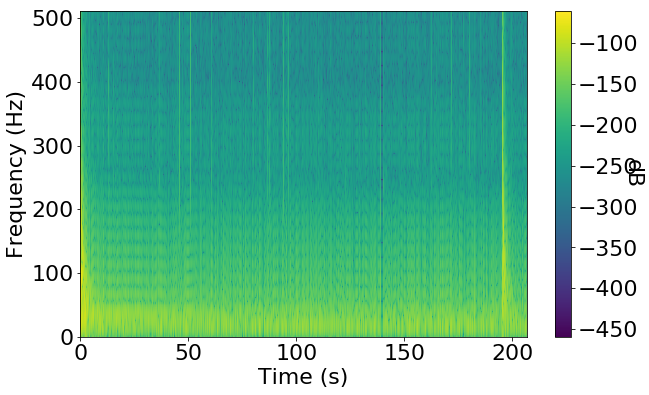

In [29]:
from scipy import signal as spsig

# Let's compute the spectrogram
NfftSTFT = 4096 # The number of frequency points for the FFT of each frame
SliceLength = int(0.05*fs) # The length of each frame (should be expressed in samples)
Overlap = int(SliceLength/4) # The overlapping between successive frames (should be expressed in samples)
[fSTFT, tSTFT, STFT] = spsig.spectrogram(data_n, fs, nperseg=SliceLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,fs/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [7]:
OutFileName = FileNameIn[:-4] + '_sonified.wav'

# For the free oscillations, we had a specific frequency that we wanted to shift to another one
# Here we can define a target duration instead

OriginalDuration = duration
TargetDuration = 12.0 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(int(OriginalDuration)) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(int(SpeedFactor)))

# (here we are speeding up the playback because the original content is infrasonic / 
# There are cases where we want to do the opposite, e.g. solar magnetic waves, acoustic emissions during rock microcracking...)
# compute the corresponding shift in frequency
# show the result with subplots original data VS. sonified data 
#      (time series / spectrum / spectrogram = no change except in the time scale)

The data is 50400-s long
Let's make a 12.0-second long sound!
This corresponds to a speed factor of: 4200


Text(0.5,1,'New Seismogram (audible)')

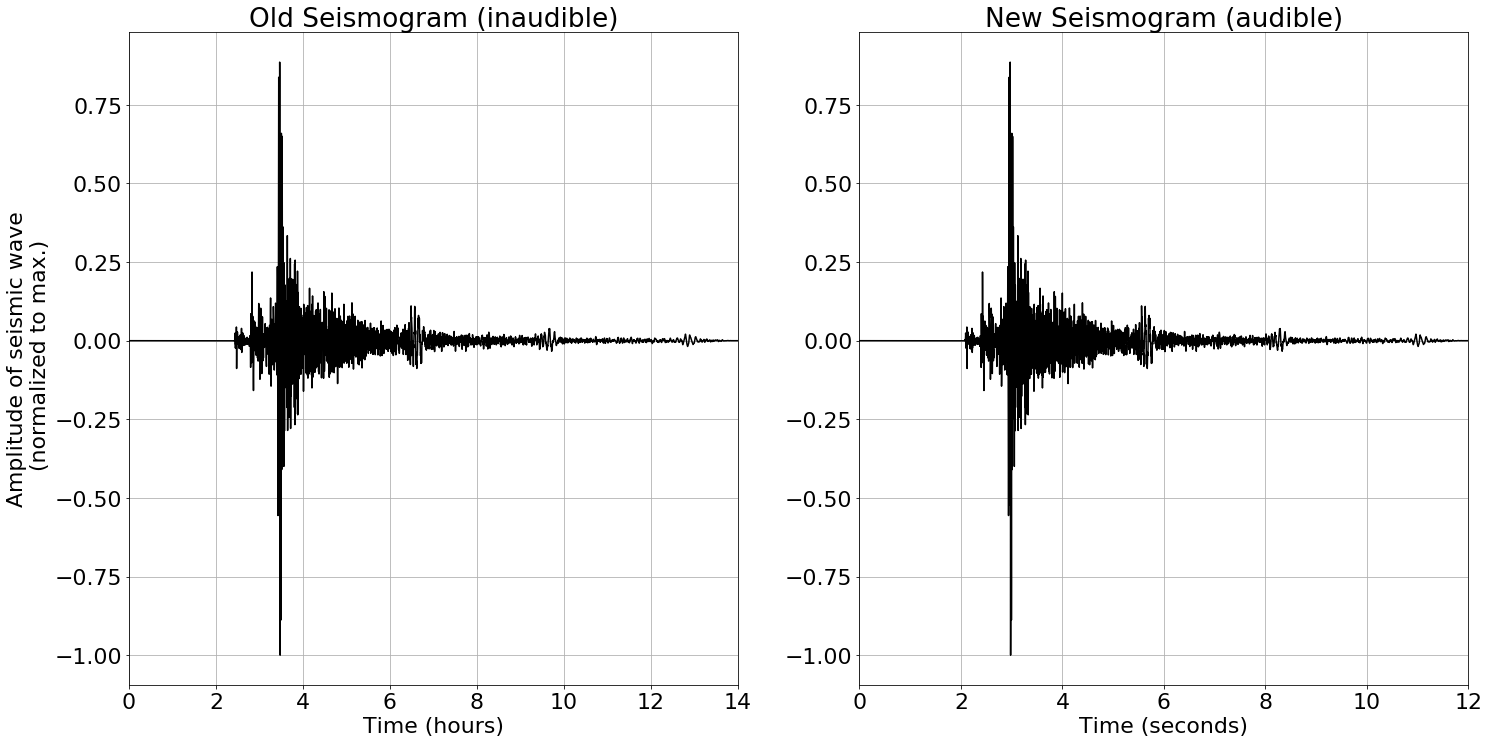

In [8]:
# Original vs. Sonified Data
plt.figure(figsize=(12*2,6*2))
plt.subplot(1,2,1)
plt.plot(t_hours,data_n,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave\n (normalized to max.)')
plt.grid()
plt.xlim([0,OriginalDuration/3600])
plt.title('Old Seismogram (inaudible)')

plt.subplot(1,2,2)
plt.plot(t_hours*3600/SpeedFactor,data_n,'k') 
plt.xlabel('Time (seconds)')
plt.grid()
plt.xlim([0,TargetDuration])
plt.title('New Seismogram (audible)')

# The difference is only in the time scale. We compress 14 hours into 12 seconds

In [9]:
# So, set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(sr*SpeedFactor)
#sr_resample = 44100

librosa.output.write_wav(DirOut + OutFileName, data_n, sr_sound, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary 
# to resample your sound.
#dataOrig, srOrig = librosa.core.load(DirOut + OutFileName, sr=sr_sound)
#data_rs = resampy.resample(dataOrig, srOrig, sr_resample)
#librosa.output.write_wav(DirOut + OutFileName, data_rs, sr_resample, norm=False)

# =========================================================
# Example 2: Much longer seismic signal: free oscillations 
### filtering to find a hidden signal ! 

In [17]:
# get the data in: 
DirIn = '../0_data_nogit/'

# This is the Sumatra earthquake (2004), recorded by a seimic station located in Albuquerque, NM
FileNameIn = 'Sumatra_2004_ANMO_14wks.VHZ' 
# Note that this data has been pre-processed (instrument response removal)
fs = 0.1 
# Datatype VHZ is downsampled to 0.1 Hz (p=10 s)

data = np.loadtxt(DirIn + FileNameIn)
duration = len(data)/fs

We have 8467200 seconds of data!
... which is 2352 hours of data!
... which is 98 days of data!


In [18]:
# make time vectors for plotting purposes only
t = np.arange(0,duration,1./fs) # in seconds
t_hours = np.arange(0,duration/3600,1./fs/3600) # in hours
t_days = np.arange(0,duration/3600/24,1./fs/3600/24) # in days

print('We have ' + str(int(duration)) + ' seconds of data!')
print('... which is ' + str(int(duration/3600)) + ' hours of data!')
print('... which is ' + str(int(duration/3600/24)) + ' days of data!')

We have 8467200 seconds of data!
... which is 2352 hours of data!
... which is 98 days of data!


In [19]:
# Compute the spectrum
Nfft = len(data)
f = np.arange(0,sr/2,sr/Nfft)
S = spfft.fft(data,Nfft); S = S[:int(Nfft/2)]
print('Frequency content ranges from ' + str(f[0]) + ' to ' + str(round(f[-1],3)) + ' Hz...')
print('Frequency content ranges from ' + str(np.log10(f[1])) + ' to ' + str(np.log10(f[-1])) + ' [log10(Hz)]')

Frequency content ranges from 0.0 to 0.05 Hz...
Frequency content ranges from -6.92773981817 to -1.30103102149 [log10(Hz)]


In [20]:
# 1) force the signal's mean value to be zero (how to kill your loudspeakers...)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers...)
# but keep the value because we want to compare the power to other data... 
maxabs = np.amax(np.absolute(data))
data_n = data/maxabs

/Users/ben/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


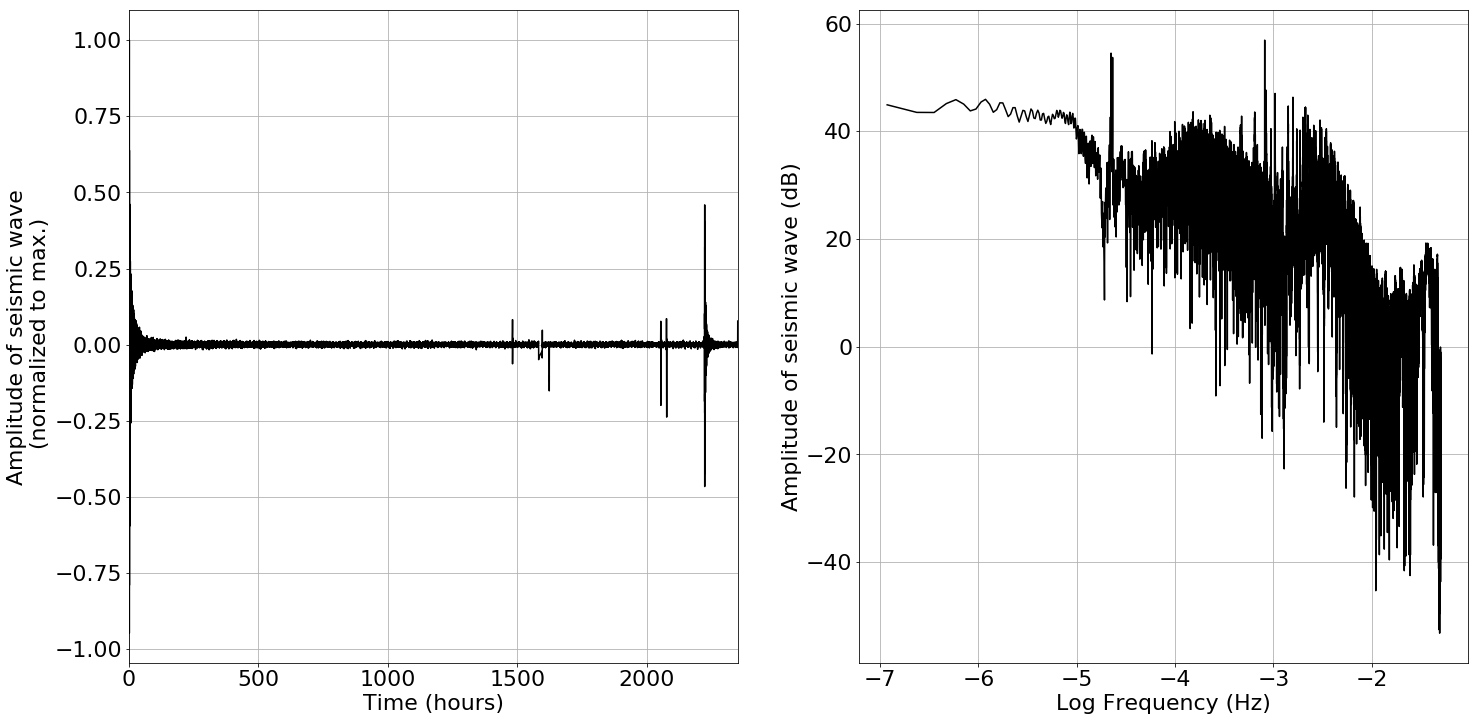

In [21]:
# plot
S = spfft.fft(data_n,Nfft)
S = S[:int(Nfft/2)]

plt.figure(figsize=(12*2,6*2))
plt.subplot(1,2,1)
plt.plot(t_hours,data_n,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave\n (normalized to max.)')
plt.grid()
plt.xlim([0,duration/3600])
plt.subplot(1,2,2)
plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Log Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()

In [ ]:
from scipy import signal as spsig

# Let's compute the spectrogram
NfftSTFT = 4096 # The number of frequency points for the FFT of each frame
SliceLength = int(0.05*fs) # The length of each frame (should be expressed in samples)
Overlap = int(SliceLength/4) # The overlapping between successive frames (should be expressed in samples)
[fSTFT, tSTFT, STFT] = spsig.spectrogram(data_n, fs, nperseg=SliceLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,fs/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [22]:
outfile_name = '14weeks_Sumatra_nofilt.wav'

OriginalDuration = duration
TargetDuration = 12.0 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(int(OriginalDuration)) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(int(SpeedFactor)))

# So, set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(sr*SpeedFactor)
librosa.output.write_wav(DirOut + outfile_name, data_n, sr_sound, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary 
# to resample your sound. if so, uncomment: 

# sr_resample = 44100
# dataOrig, srOrig = librosa.core.load(DirOut + OutFileName, sr=sr_sound)
# data_rs = resampy.resample(dataOrig, srOrig, sr_resample)
# librosa.output.write_wav(DirOut + OutFileName, data_rs, sr_resample, norm=False)

The data is 8467200-s long
Let's make a 12.0-second long sound!
This corresponds to a speed factor of: 705600


In [ ]:
# go back and trim it ! to hear the surface waves throbbing ! 

In [23]:
# then try FILTERING IT ! 

# =========================================================
# Example 3: LIGO data   
## Laser Interferometer Gravitational-Wave Observatory  (DOI: 10.1103/PhysRevLett.116.061102)
## https://www.ligo.org/
### Much, much much lower amplitude than seismic waves: compare the spectra !
### (too short for direct sonification !)  

In [39]:
# get the data in: 
DirIn = '../0_data_examples/LIGO/'

# This is the Sumatra earthquake (2004), recorded by a seimic station located in Albuquerque, NM
FileNameIn = 'obs_HanfordWA.txt' 
# https://www.gw-openscience.org/GWTC-1-confident/
# Note that this data has been pre-processed (instrument response removal)
fs = 4096 # Hz (looks like this is not correct ! )
# Datatype VHZ is downsampled to 0.1 Hz (p=10 s)

data = np.loadtxt(DirIn + FileNameIn)
print(data.shape)
print(data[0,0])
# note that np.loadtext automatically skipped the column headers ! 

time = np.squeeze(data[0:-1,0])
strain = np.squeeze(data[0:-1,1])
print(time.shape)

print(time[-1])
#plt.plot(time-time[0])

duration0 = (time[-1]-time[0])
dt = duration0/len(time) # since we don't a priori know if time is regularly spaced (probably is)
print(duration0)

fs = 1/dt 
print(fs)

#duration = len(data)/fs
#print(duration)

(3441, 2)
0.25
(3440,)
0.459899902344
0.209899902344
16388.7641756


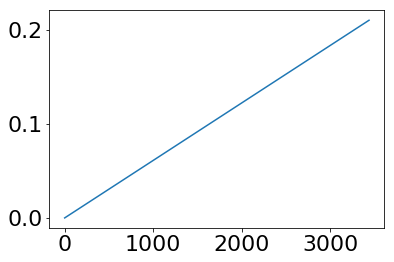

In [34]:
# play it directly ! 
data = strain 


In [ ]:
from scipy import signal as spsig

# Let's compute the spectrogram
NfftSTFT = 4096 # The number of frequency points for the FFT of each frame
SliceLength = int(0.05*fs) # The length of each frame (should be expressed in samples)
Overlap = int(SliceLength/4) # The overlapping between successive frames (should be expressed in samples)
[fSTFT, tSTFT, STFT] = spsig.spectrogram(data_n, fs, nperseg=SliceLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,fs/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)